In [34]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
from torchvision.transforms import Resize
import torchvision
from vit_pytorch.efficient import ViT
from linformer import Linformer
from torchvision.io import read_image
from PIL import Image
from data_preprocess import get_data_loader
from data_preprocess import CustomDataset
from tqdm import tqdm
import time as timer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
1
Quadro RTX 8000


In [3]:
# Training settings
batch_size = 64
epochs = 1
lr = 3e-5
gamma = 0.7
seed = 42

trans = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

train_loader, val_loader, test_loader = get_data_loader(batch_size,trans)
device = 'cuda'

In [4]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

evit = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

evit.load_state_dict(torch.load("9040.pt"))


<All keys matched successfully>

In [5]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
evit_optimizer = optim.AdamW(evit.parameters(), lr=lr)
# scheduler
evit_scheduler = StepLR(evit_optimizer, step_size=1, gamma=gamma)


In [27]:
def train(model, model_name ,epochs, criterion, optimizer, scheduler = None):
    train_acc = []
    val_acc = []
    test_acc = []
    for epoch in range(epochs):
        print(f"===== Epoch : {epoch+1} ======\n", flush = True)
        start = timer.time()
        train_loss = 0
        train_accuracy = 0
        print("Training:", flush = True)
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean().item()
            train_accuracy += acc / len(train_loader)
            train_loss += loss.item() / len(train_loader)


        with torch.no_grad():
            val_accuracy = 0
            val_loss = 0
            print("Validation:", flush = True)
            for data, label in tqdm(val_loader):
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean().item()
                val_accuracy += acc / len(val_loader)
                val_loss += loss.item() / len(val_loader)


            test_accuracy = 0
            test_loss = 0
            print("Test:", flush = True)
            for data, label in tqdm(test_loader):
                data = data.cuda()
                label = label.cuda()

                test_output = model(data)
                loss = criterion(test_output, label)

                acc = (test_output.argmax(dim=1) == label).float().mean().item()
                test_accuracy += acc / len(test_loader)
                test_loss += loss.item() / len(test_loader)

        end = timer.time()
        print(
            f"Epoch : {epoch+1} - training loss : {train_loss:.4f} -  training acc: {train_accuracy:.4f} - val_loss : {val_loss:.4f} - val_acc: {val_accuracy:.4f}- test_loss : {test_loss:.4f} - test_acc: {test_accuracy:.4f} - time: {end - start: 4f}\n", flush = True)
        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)
        test_acc.append(test_accuracy)
        save_name = model_name + str(epoch+1) + "TE.pt"
        if test_accuracy > 0.85:
            torch.save(model.state_dict(), save_name)
    dic = {"train_acc":train_acc,"val_acc":val_acc,"test_acc":test_acc}
    df = pd.DataFrame(dic)
    csv_name = model_name + "_acc.csv"
    df.to_csv(csv_name)

In [28]:
train(evit, "evit", 1, criterion, evit_optimizer)

===== Epoch : 1 ======

Training:


100%|██████████| 375/375 [01:52<00:00,  3.33it/s]

Validation:



100%|██████████| 94/94 [00:29<00:00,  3.20it/s]

Test:



100%|██████████| 7/7 [00:06<00:00,  1.02it/s]

Epoch : 1 - training loss : 0.0616 -  training acc: 0.9765 - val_loss : 0.1050 - val_acc: 0.9649- test_loss : 0.3717 - test_acc: 0.8683 - time:  148.778842



In [12]:
cm = np.zeros([2,2])
with torch.no_grad():
    test_accuracy = 0
    test_loss = 0
    print("Test:", flush = True)
    for data, label in tqdm(test_loader):
        data = data.cuda()
        label = label.cuda()

        test_output = evit(data)
        loss = criterion(test_output, label)

        out = test_output.argmax(dim=1).cpu()
        cm += confusion_matrix(label.cpu().numpy(), out.numpy())
        

Test:


100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


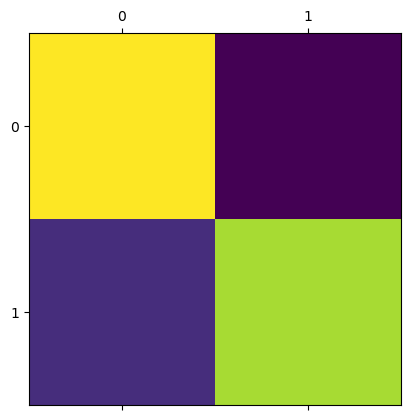

In [36]:
plt.matshow(cm)

In [15]:
6*64


384

In [17]:
train_df = pd.read_csv('data/train.txt', sep=" ", header=None)
test_df = pd.read_csv('data/test.txt', sep=" ", header=None)

In [18]:
train_df

,0,1,2,3
0,5,ARDSSevere.png,negative,cohen
1,25,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen
2,26,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen
3,27,ards-secondary-to-tiger-snake-bite.png,negative,cohen
4,28,pneumocystis-pneumonia-2-PA.png,negative,cohen
...,...,...,...,...
29981,55204bb8-89fc-449d-8563-e91654abea9d,55204bb8-89fc-449d-8563-e91654abea9d.png,negative,rsna
29982,0f4b80b6-fd39-451f-aebf-7cdb1b655c0b,0f4b80b6-fd39-451f-aebf-7cdb1b655c0b.png,negative,rsna
29983,5fb64e85-62ef-4852-8ad1-f799015c8cc3,5fb64e85-62ef-4852-8ad1-f799015c8cc3.png,negative,rsna
29984,c57ad4fd-3aa8-4ae8-a262-7336360d8265,c57ad4fd-3aa8-4ae8-a262-7336360d8265.png,negative,rsna


In [19]:
test_df

,0,1,2,3
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord
...,...,...,...,...
395,a77b32f6-1999-4cc6-8a0d-1ef7e53850f0,a77b32f6-1999-4cc6-8a0d-1ef7e53850f0.png,negative,rsna
396,41bf2042-53a2-44a8-9a29-55e643af5ac0,41bf2042-53a2-44a8-9a29-55e643af5ac0.png,negative,rsna
397,ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed,ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed.png,negative,rsna
398,abff4044-3c0a-458f-b0c7-04254be7fc0c,abff4044-3c0a-458f-b0c7-04254be7fc0c.png,negative,rsna


In [22]:
train_df[train_df[2] == "negative"]

,0,1,2,3
0,5,ARDSSevere.png,negative,cohen
1,25,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen
2,26,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen
3,27,ards-secondary-to-tiger-snake-bite.png,negative,cohen
4,28,pneumocystis-pneumonia-2-PA.png,negative,cohen
...,...,...,...,...
29981,55204bb8-89fc-449d-8563-e91654abea9d,55204bb8-89fc-449d-8563-e91654abea9d.png,negative,rsna
29982,0f4b80b6-fd39-451f-aebf-7cdb1b655c0b,0f4b80b6-fd39-451f-aebf-7cdb1b655c0b.png,negative,rsna
29983,5fb64e85-62ef-4852-8ad1-f799015c8cc3,5fb64e85-62ef-4852-8ad1-f799015c8cc3.png,negative,rsna
29984,c57ad4fd-3aa8-4ae8-a262-7336360d8265,c57ad4fd-3aa8-4ae8-a262-7336360d8265.png,negative,rsna


In [23]:
29986-13992

15994

In [24]:
test_df[test_df[2] == "negative"]

,0,1,2,3
200,47c78742-4998-4878-aec4-37b11b1354ac,47c78742-4998-4878-aec4-37b11b1354ac.png,negative,rsna
201,8989e25c-a698-48fc-b428-fff56931fc8f,8989e25c-a698-48fc-b428-fff56931fc8f.png,negative,rsna
202,7fb3786c-5045-4a90-981d-c55b53d4d5d3,7fb3786c-5045-4a90-981d-c55b53d4d5d3.png,negative,rsna
203,766b8aea-3b43-4a34-b675-09f373ca066b,766b8aea-3b43-4a34-b675-09f373ca066b.png,negative,rsna
204,f6236cb5-cc36-4ec4-895c-d11ce043341d,f6236cb5-cc36-4ec4-895c-d11ce043341d.png,negative,rsna
...,...,...,...,...
395,a77b32f6-1999-4cc6-8a0d-1ef7e53850f0,a77b32f6-1999-4cc6-8a0d-1ef7e53850f0.png,negative,rsna
396,41bf2042-53a2-44a8-9a29-55e643af5ac0,41bf2042-53a2-44a8-9a29-55e643af5ac0.png,negative,rsna
397,ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed,ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed.png,negative,rsna
398,abff4044-3c0a-458f-b0c7-04254be7fc0c,abff4044-3c0a-458f-b0c7-04254be7fc0c.png,negative,rsna


In [25]:
224/32


7.0

In [32]:
X,y = next(iter(train_loader))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


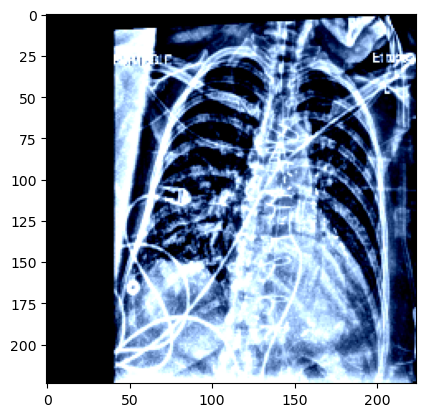

In [37]:

plt.imshow( X[0].permute(1, 2, 0)  )

In [42]:
X[0].permute(1, 2, 0).shape
img = X[0].permute(1, 2, 0)
img.shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


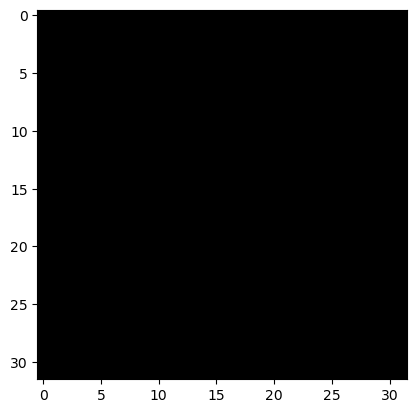

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


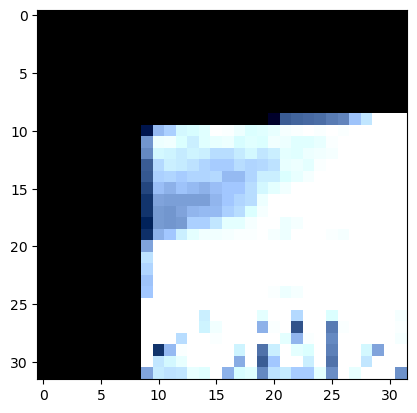

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


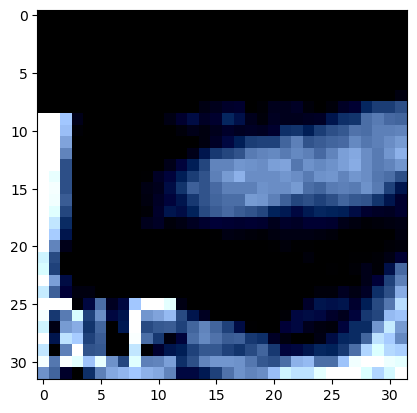

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


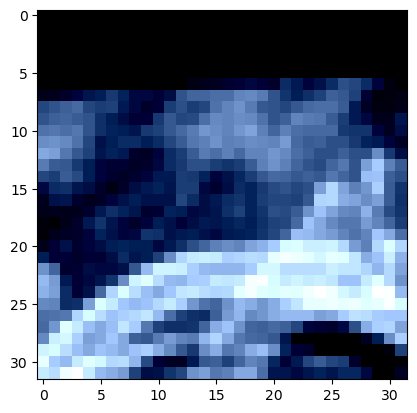

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


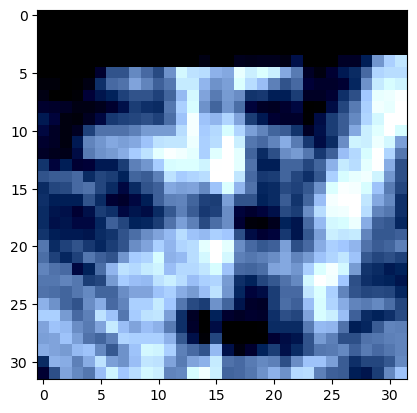

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


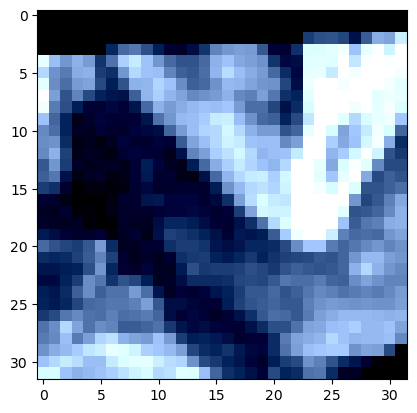

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


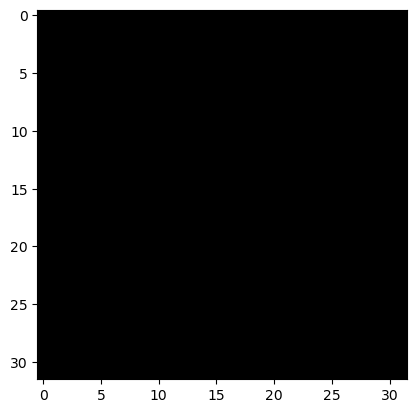

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


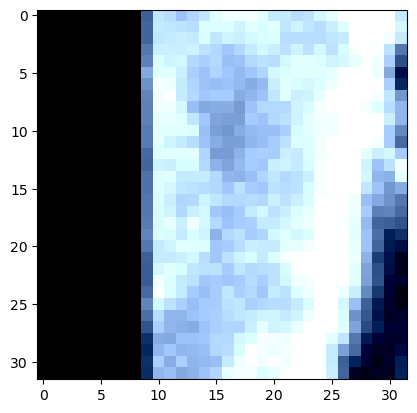

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


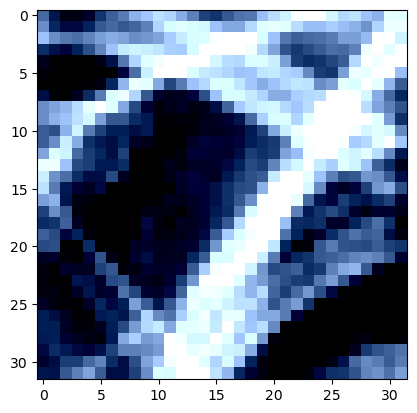

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


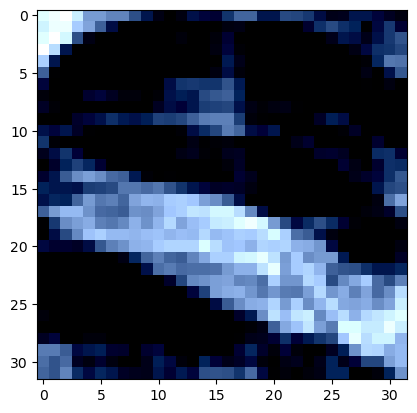

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


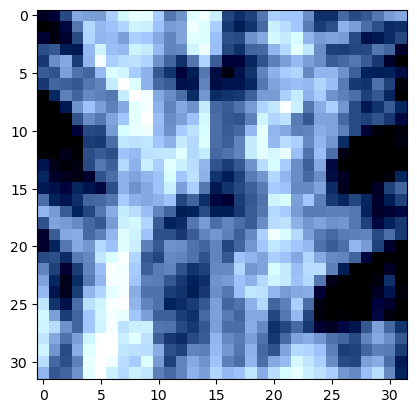

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


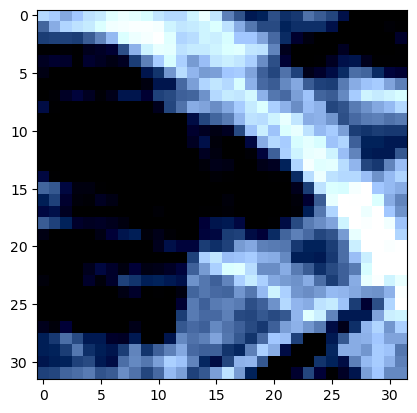

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


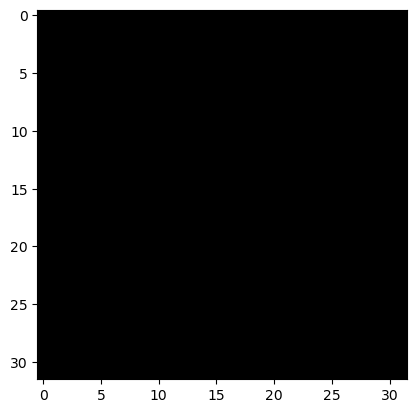

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


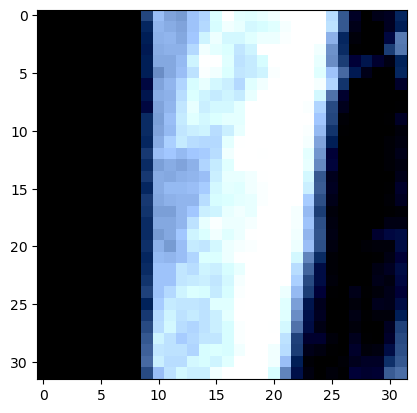

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


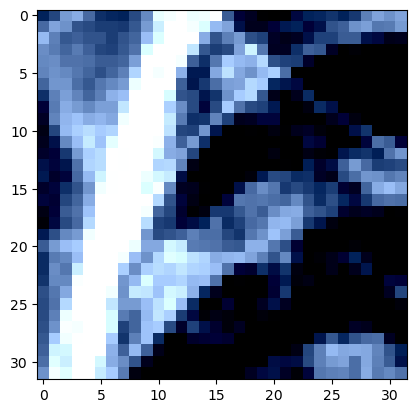

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


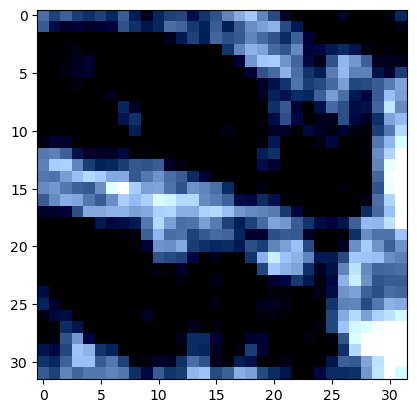

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


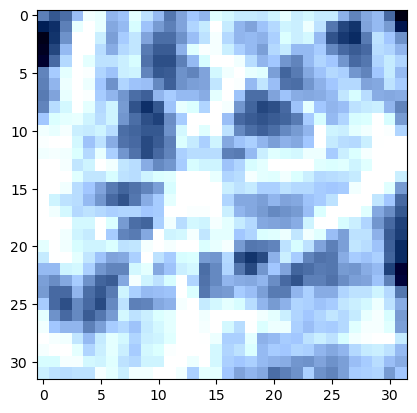

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


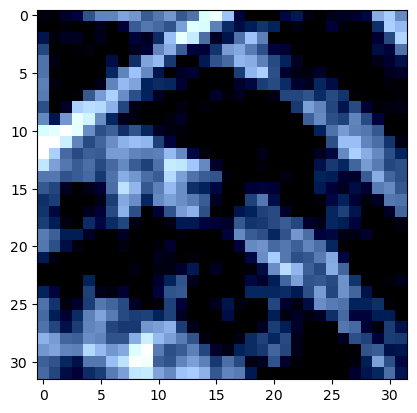

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


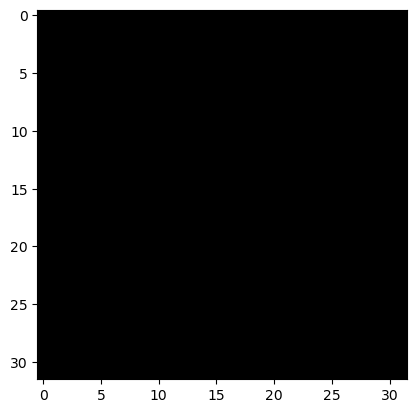

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


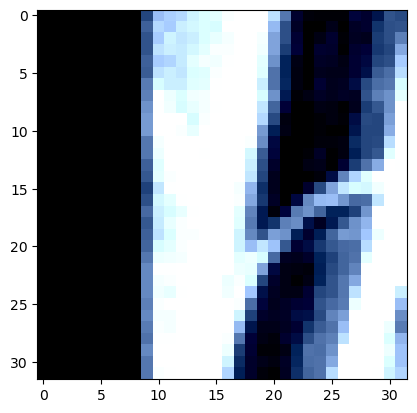

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


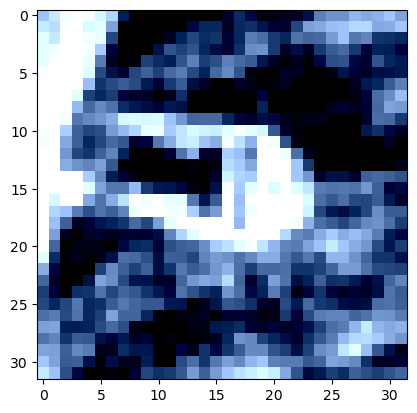

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


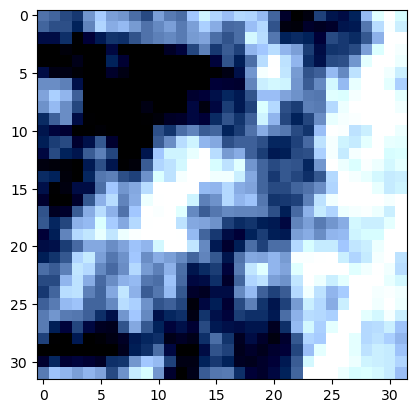

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


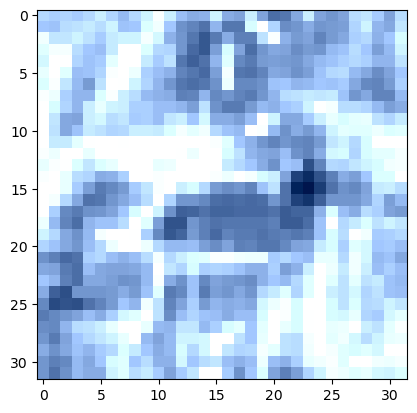

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


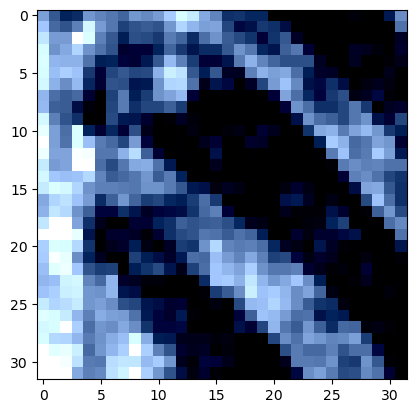

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


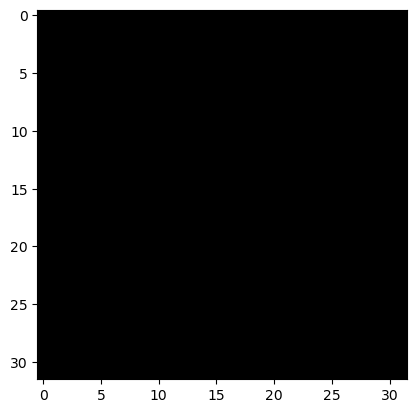

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


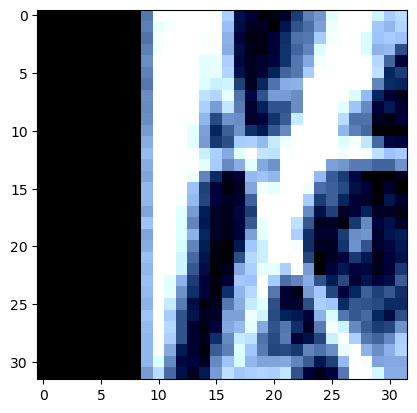

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


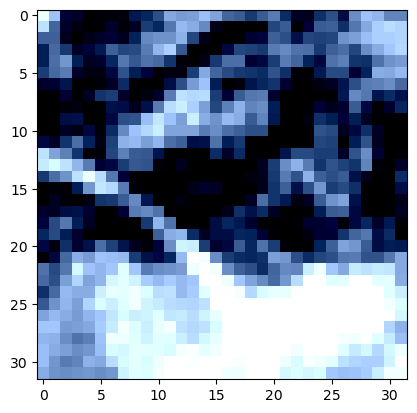

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


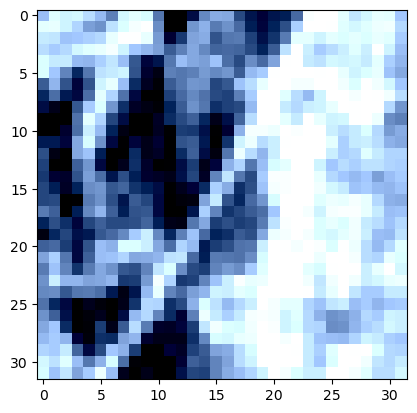

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


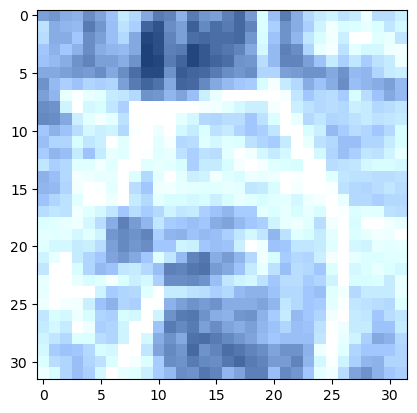

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


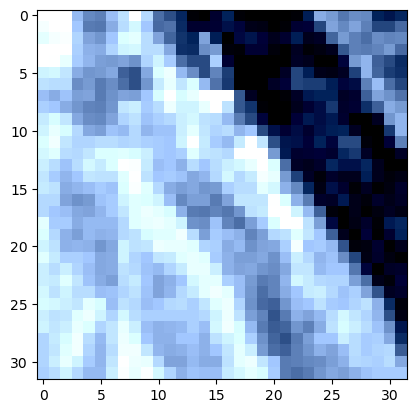

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


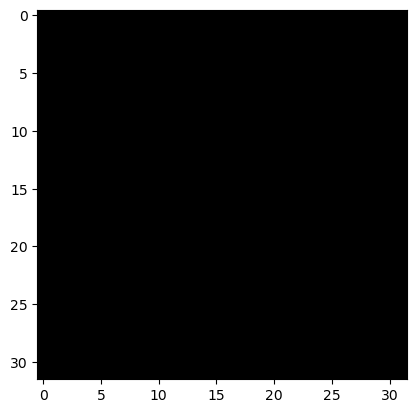

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


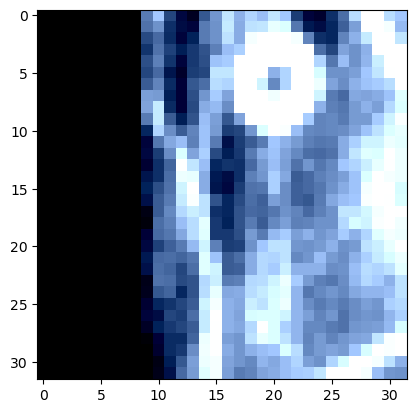

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


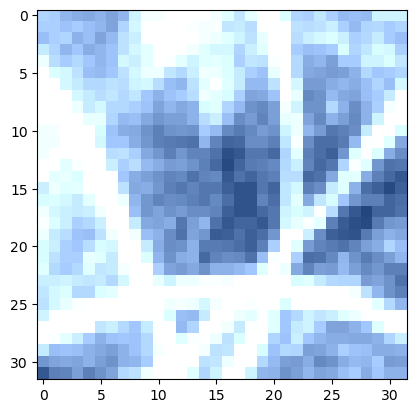

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


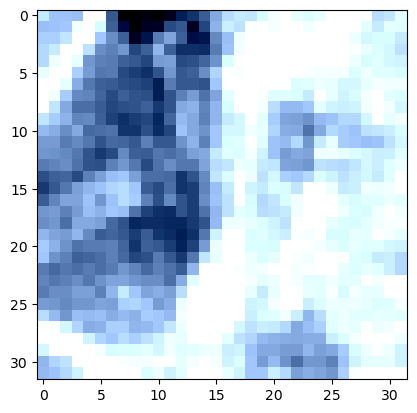

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


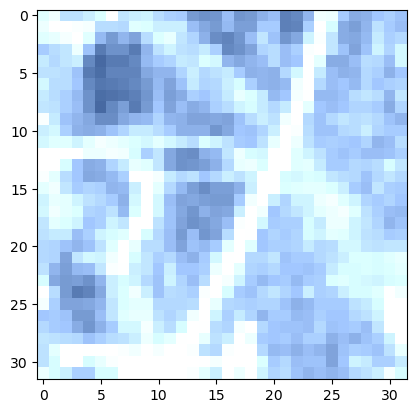

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


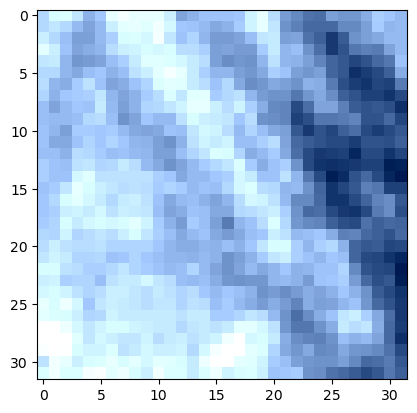

In [51]:
l = 0
r = 32 
u = 0
d = 32
for i in range(6):
    l = 32 * i
    r = 32+l
    for j in range(6):
        u = 32 * j
        d = 32+u
        plt.imshow(img[l:r, u:d])
        plt.show()

In [44]:
32*6 + 32

224